Dataset used: https://www.kaggle.com/datasets/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests/data

In [ ]:
def path_to_stock_data(symbol):
  return '/content/drive/MyDrive/ML for Trading/data/' + symbol + '.csv'

In [ ]:
# !pip install feedparser
# !pip install transformers

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
from transformers import AutoTokenizer
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification
import scipy.optimize as spo
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/analyst_ratings_processed.csv')

In [ ]:
print('First 5 rows of data')
print(df.head())

First 5 rows of data
   Unnamed: 0                                              title  \
0         0.0            Stocks That Hit 52-Week Highs On Friday   
1         1.0         Stocks That Hit 52-Week Highs On Wednesday   
2         2.0                      71 Biggest Movers From Friday   
3         3.0       46 Stocks Moving In Friday's Mid-Day Session   
4         4.0  B of A Securities Maintains Neutral on Agilent...   

                        date stock  
0  2020-06-05 10:30:00-04:00     A  
1  2020-06-03 10:45:00-04:00     A  
2  2020-05-26 04:30:00-04:00     A  
3  2020-05-22 12:45:00-04:00     A  
4  2020-05-22 11:38:00-04:00     A  


In [ ]:
ticker = 'AAPL'

In [ ]:
aapl = df[df['stock'] == ticker][['title', 'date', 'stock']].reset_index()

In [ ]:
print('First 5 rows of Apple news')
print(aapl.head())

First 5 rows of Apple news
   index                                              title  \
0   3668  Tech Stocks And FAANGS Strong Again To Start D...   
1   3669      10 Biggest Price Target Changes For Wednesday   
2   3670  Benzinga Pro's Top 5 Stocks To Watch For Wed.,...   
3   3671  Deutsche Bank Maintains Buy on Apple, Raises P...   
4   3672  Apple To Let Users Trade In Their Mac Computer...   

                        date stock  
0  2020-06-10 11:33:00-04:00  AAPL  
1  2020-06-10 08:14:00-04:00  AAPL  
2  2020-06-10 07:53:00-04:00  AAPL  
3  2020-06-10 07:19:00-04:00  AAPL  
4  2020-06-10 06:27:00-04:00  AAPL  


In [ ]:
print(aapl.shape)

(469, 4)


In [ ]:
aapl['date'] = pd.to_datetime(aapl['date'])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")

tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def scale_sentiment(sentiments):
    mm = MinMaxScaler()
    sent_proc = np.array(sentiments).reshape(-1, 1)
    return mm.fit_transform(sent_proc)

In [ ]:
df_description = aapl

In [ ]:
def _chunks(lst, n):
    """ Yield n-sized chunks from list. """
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

batch_size = 10

result = []

for batch in _chunks(df_description['title'].tolist(), batch_size):
  encoded = tokenizer(batch, add_special_tokens=True, max_length=256,
                      padding='max_length',return_attention_mask=True,
                      return_tensors='pt', truncation=True)
  input_ids = torch.cat([encoded['input_ids']], dim=0).to('cuda')
  attention_mask = torch.cat([encoded['attention_mask']], dim=0).to('cuda')

  model = AutoModelForSequenceClassification.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT").eval().to('cuda')
  model_output = model(input_ids, token_type_ids=None, attention_mask=attention_mask)
  logits = model_output[0]
  softmax_output = F.softmax(logits, dim=1).cpu().detach().numpy()

  sentiment_score = softmax_output[:, 2] - softmax_output[:, 0]

  mean_score = np.array(sentiment_score).ravel().mean()

  scaled_sentiment_scores = scale_sentiment(sentiment_score)

  result.append(scaled_sentiment_scores)

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [ ]:
merged_array = np.concatenate(result)
df_description['sentiment'] = merged_array

df_description.head()

,index,title,date,stock,sentiment
0,3668,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10 11:33:00-04:00,AAPL,8.732903e-07
1,3669,10 Biggest Price Target Changes For Wednesday,2020-06-10 08:14:00-04:00,AAPL,3.336071e-07
2,3670,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10 07:53:00-04:00,AAPL,0.000000e+00
3,3671,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10 07:19:00-04:00,AAPL,1.220459e-06
4,3672,Apple To Let Users Trade In Their Mac Computer...,2020-06-10 06:27:00-04:00,AAPL,1.172728e-06


In [ ]:
df_description.describe()

,index,sentiment
count,469.000000,469.000000
mean,3902.000000,0.429110
std,135.532899,0.428148
min,3668.000000,0.000000
25%,3785.000000,0.000006
50%,3902.000000,0.394052
75%,4019.000000,0.999470
max,4136.000000,1.000000


In [ ]:
date_from, date_to = min(df_description['date'].dt.date), max(df_description['date'].dt.date)
print(date_from, date_to)

2020-03-09 2020-06-10


In [ ]:
def path_to_stock_data(symbol):
  return '/content/drive/MyDrive/ML for Trading/data/' + symbol + '.csv'

<Axes: >

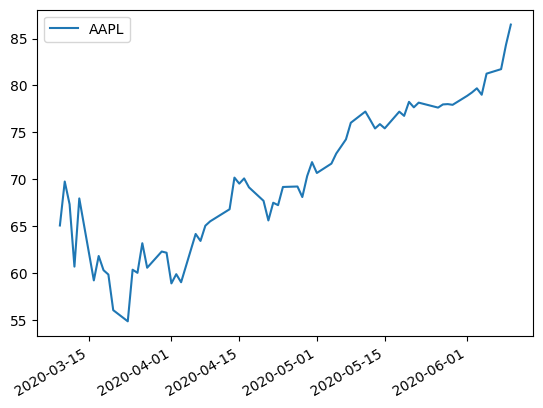

In [ ]:
def get_data(symbols, dates, add_SPY=True):

  if 'SPY' not in symbols:
    symbols.insert(0, 'SPY')

  df = pd.DataFrame(index=dates)

  for symbol in symbols:
    df_temp = pd.read_csv(path_to_stock_data(symbol), index_col="Date",
                          parse_dates=True, usecols=['Date', 'Adj Close'], na_values=['nan'])
    df_temp = df_temp.rename(columns={'Adj Close': symbol})
    df = df.join(df_temp)
    if symbol == 'SPY':
      df = df.dropna(subset=['SPY'])

  if not add_SPY:
    df = df.drop(columns=['SPY'])

  return df

dates = pd.date_range(date_from, date_to)

symbols = ['AAPL']

df = get_data(symbols, dates, add_SPY=False)

df.plot()

In [ ]:
start_val = 1000000
start_date = date_from
end_date = date_to
symbols = ['AAPL']
allocs = [1.0]
dates = pd.date_range(start_date, end_date)

prices = get_data(symbols, dates, add_SPY=False)

def get_neg_sharpe(allocs, prices):
  normed = prices / prices.iloc[0, :]
  alloced = normed * np.array(allocs)
  pos_vals = alloced * start_val
  portfolio_val = pos_vals.sum(axis=1)
  daily_rets = portfolio_val / portfolio_val.shift(1) - 1
  daily_rets = daily_rets[1:]
  daily_rf = (1.0 + 0) ** (1 / 252) - 1
  sharpe = -np.sqrt(252) * np.mean(daily_rets - daily_rf) / np.std(daily_rets)
  return sharpe

eq_cons = {'type' : 'eq',
           'fun'  : lambda x: np.sum(x) - 1}

bounds = spo.Bounds(lb=0, ub=1)

In [ ]:
optimal_alloc = spo.minimize(get_neg_sharpe, allocs, args=(prices,), bounds=[(0,1)], constraints=eq_cons, method='SLSQP', options={'disp': True})

print(optimal_alloc)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.137859087633799
            Iterations: 1
            Function evaluations: 2
            Gradient evaluations: 1
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -2.137859087633799
       x: [ 1.000e+00]
     nit: 1
     jac: [-3.874e-07]
    nfev: 2
    njev: 1


In [ ]:
aapl.head()

,index,title,date,stock,sentiment
0,3668,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10 11:33:00-04:00,AAPL,8.732903e-07
1,3669,10 Biggest Price Target Changes For Wednesday,2020-06-10 08:14:00-04:00,AAPL,3.336071e-07
2,3670,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10 07:53:00-04:00,AAPL,0.000000e+00
3,3671,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10 07:19:00-04:00,AAPL,1.220459e-06
4,3672,Apple To Let Users Trade In Their Mac Computer...,2020-06-10 06:27:00-04:00,AAPL,1.172728e-06


In [ ]:
aapl['datetime'] = aapl.date
aapl.date = aapl['datetime'].dt.date
aapl.head()

,index,title,date,stock,sentiment,datetime
0,3668,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10,AAPL,8.732903e-07,2020-06-10 11:33:00-04:00
1,3669,10 Biggest Price Target Changes For Wednesday,2020-06-10,AAPL,3.336071e-07,2020-06-10 08:14:00-04:00
2,3670,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10,AAPL,0.000000e+00,2020-06-10 07:53:00-04:00
3,3671,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10,AAPL,1.220459e-06,2020-06-10 07:19:00-04:00
4,3672,Apple To Let Users Trade In Their Mac Computer...,2020-06-10,AAPL,1.172728e-06,2020-06-10 06:27:00-04:00


Text(0.5, 1.0, 'Number of headlines on a date')

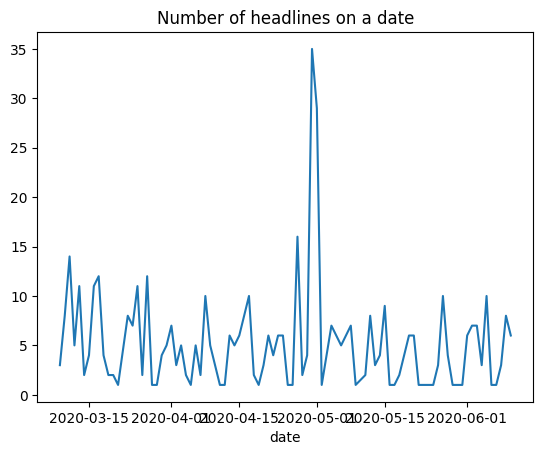

In [ ]:
aapl.groupby('date')['sentiment'].count().plot()
plt.title('Number of headlines on a date')

In [ ]:
aapl_sentiments = pd.DataFrame(aapl.groupby('date')['sentiment'].mean())
aapl_sentiments.head()

,sentiment
date,
2020-03-09,0.000004
2020-03-10,0.375009
2020-03-11,0.856927
2020-03-12,0.599687
2020-03-13,0.605197


Text(0.5, 1.0, 'Sentiment of news headlines on Apple stock')

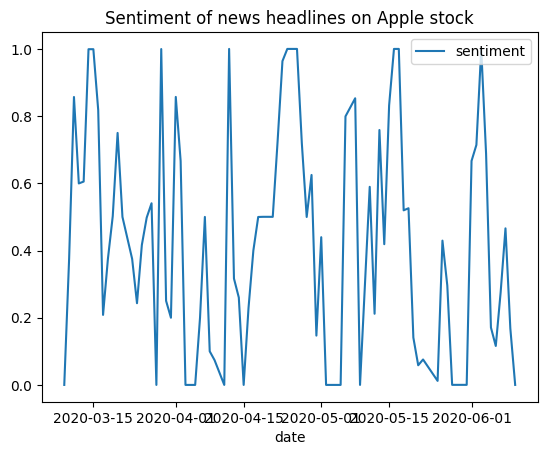

In [ ]:
aapl_sentiments.plot()
plt.title('Sentiment of news headlines on Apple stock')

In [ ]:
df.head()

,AAPL
2020-03-09,65.067307
2020-03-10,69.753555
2020-03-11,67.330971
2020-03-12,60.681721
2020-03-13,67.951904


In [ ]:
merged_df = pd.merge(aapl_sentiments, df, left_index=True, right_index=True, how='outer')

In [ ]:
merged_df

,sentiment,AAPL
2020-03-09,0.000004,65.067307
2020-03-10,0.375009,69.753555
2020-03-11,0.856927,67.330971
2020-03-12,0.599687,60.681721
2020-03-13,0.605197,67.951904
...,...,...
2020-06-06,0.115899,NaN
2020-06-07,0.275192,NaN
2020-06-08,0.465992,81.737511
2020-06-09,0.168274,84.318626


In [ ]:
aapl_sentiments.shape, df.shape, merged_df.shape

((86, 1), (66, 1), (87, 2))

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87 entries, 2020-03-09 to 2020-06-10
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  86 non-null     float32
 1   AAPL       66 non-null     float64
dtypes: float32(1), float64(1)
memory usage: 1.7 KB


In [ ]:
def save_file(df, date_from, date_to, ticker):
  file_path = '/content/drive/MyDrive/altdata/saved-files' + '/' + str(date_from) + '-' + str(date_to) + '-' + ticker + '.csv'
  print('saved to:')
  print(file_path)
  df.to_csv(file_path)

In [ ]:
save_file(merged_df, date_from, date_to, 'AAPL')

# Testing strategies

   Unnamed: 0  sentiment       AAPL       SMA5  SMA20  SMA_Crossover_Signal  \
0  2020-03-09   0.000004  65.067307        NaN    NaN                     0   
1  2020-03-10   0.375009  69.753555        NaN    NaN                     0   
2  2020-03-11   0.856927  67.330971        NaN    NaN                     0   
3  2020-03-12   0.599687  60.681721        NaN    NaN                     0   
4  2020-03-13   0.605197  67.951904  66.157092    NaN                     0   

   Sentiment_Signal  Combined_Signal  AAPL_Return  SMA_Portfolio_Return  \
0                -1                0          NaN                   NaN   
1                -1                0     0.072022                   0.0   
2                 1                0    -0.034731                  -0.0   
3                 1                0    -0.098755                  -0.0   
4                 1                0     0.119808                   0.0   

   Sentiment_Portfolio_Return  Combined_Portfolio_Return  
0              

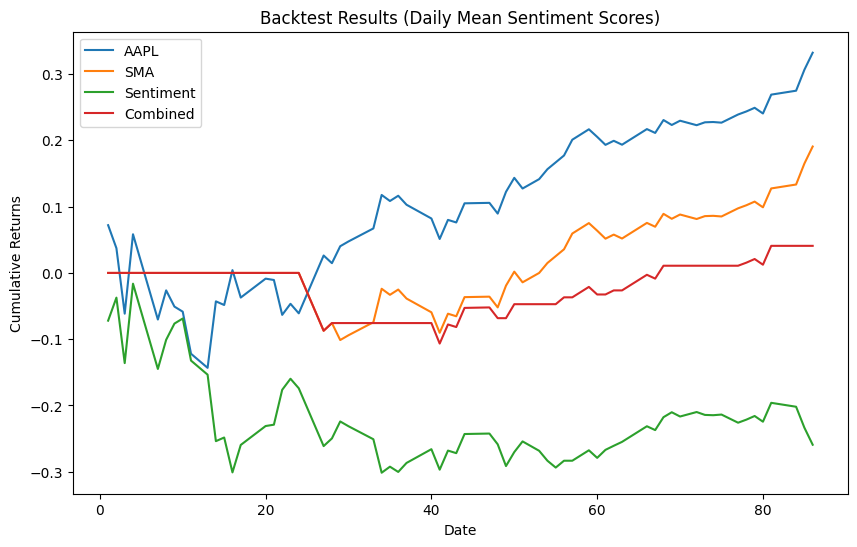

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_daily = pd.read_csv('/content/drive/MyDrive/altdata/saved-files/2020-03-09-2020-06-10-AAPL.csv')

# drop na
df_daily = df_daily.dropna(subset=['AAPL'])

# SMA crossover
df_daily['SMA5'] = df_daily['AAPL'].rolling(window=5).mean()
df_daily['SMA20'] = df_daily['AAPL'].rolling(window=20).mean()
df_daily['SMA_Crossover_Signal'] = 0
df_daily.loc[df_daily['SMA5'] > df_daily['SMA20'], 'SMA_Crossover_Signal'] = 1
df_daily.loc[df_daily['SMA5'] < df_daily['SMA20'], 'SMA_Crossover_Signal'] = -1

# sentiment thresholding
sentiment_threshold = 0.5
df_daily['Sentiment_Signal'] = 0
df_daily.loc[df_daily['sentiment'] > sentiment_threshold, 'Sentiment_Signal'] = 1
df_daily.loc[df_daily['sentiment'] < sentiment_threshold, 'Sentiment_Signal'] = -1

# combined
df_daily['Combined_Signal'] = df_daily['SMA_Crossover_Signal'] + df_daily['Sentiment_Signal']
df_daily['Combined_Signal'] = df_daily['Combined_Signal'].apply(lambda x: 1 if x == 2 else (-1 if x == -2 else 0))

# Backtest
df_daily['AAPL_Return'] = df_daily['AAPL'].pct_change()
df_daily['SMA_Portfolio_Return'] = df_daily['SMA_Crossover_Signal'].shift(1) * df_daily['AAPL_Return']
df_daily['Sentiment_Portfolio_Return'] = df_daily['Sentiment_Signal'].shift(1) * df_daily['AAPL_Return']
df_daily['Combined_Portfolio_Return'] = df_daily['Combined_Signal'].shift(1) * df_daily['AAPL_Return']

print(df_daily.head())

df_daily[['AAPL_Return', 'SMA_Portfolio_Return', 'Sentiment_Portfolio_Return', 'Combined_Portfolio_Return']].cumsum().plot(figsize=(10, 6))
plt.title('Backtest Results (Daily Mean Sentiment Scores)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(['AAPL', 'SMA', 'Sentiment', 'Combined'])
plt.show()
